<a href="https://colab.research.google.com/github/navyarshetty534/recommendation/blob/main/Copy_of_kaggel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [ ]:
df1 = pd.read_csv('/content/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])
df2 = pd.read_csv('/content/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('/content/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('/content/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 1 shape: (2293195, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN
Dataset 2 shape: (2293223, 2)
Dataset 3 shape: (2293226, 2)
Dataset 4 shape: (2293226, 2)


In [ ]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (2293195, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


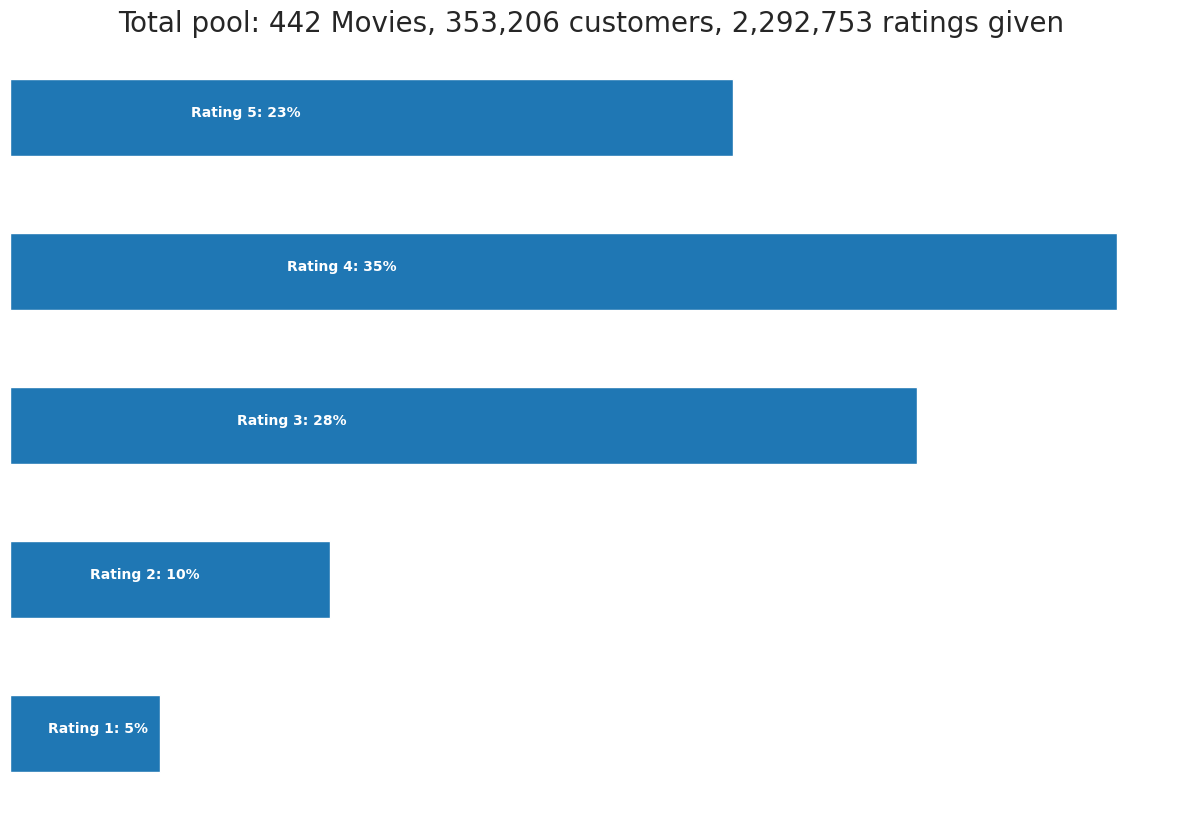

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


In [ ]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.   1.   1. ... 442. 442. 442.]
Length: 2292753


In [ ]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

<ipython-input-30-6f95882c24ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1


<ipython-input-30-6f95882c24ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 2130.0
Customer minimum times of review: 7.0


In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (2292753, 3)
After Trim Shape: (1546952, 3)
-Data Examples-
      Cust_Id  Rating  Movie_Id
5106   824097     2.0         8


In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(114739, 133)


In [ ]:
df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


<ipython-input-34-d1f084f818ce>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)
Skipping line 72: expected 3 fields, saw 4
Skipping line 264: expected 3 fields, saw 5
Skipping line 350: expected 3 fields, saw 4
Skipping line 366: expected 3 fields, saw 4
Skipping line 394: expected 3 fields, saw 4
Skipping line 466: expected 3 fields, saw 4
Skipping line 582: expected 3 fields, saw 4
Skipping line 600: expected 3 fields, saw 4
Skipping line 670: expected 3 fields, saw 4
Skipping line 672: expected 3 fields, saw 4
Skipping line 729: expected 3 fields, saw 4
Skipping line 776: expected 3 fields, saw 4
Skipping line 827: expected 3 fields, saw 4
Skipping line 834: expected 3 fields, saw 4
Skipping line 891: expected 3 fields, saw 4
Skipping line

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.95999055, 0.95621471, 0.95809175, 0.95606359, 0.95780069]),
 'test_mae': array([0.75430516, 0.75317575, 0.75401642, 0.75162782, 0.75425225]),
 'fit_time': (33.429394483566284,
  31.465288877487183,
  34.0604248046875,
  31.51583981513977,
  32.31590247154236),
 'test_time': (5.498424291610718,
  5.008506536483765,
  5.147290229797363,
  5.479987144470215,
  5.956091403961182)}

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57        Richard III
175    Reservoir Dogs
311           Ed Wood
329             Dogma
331       Chasing Amy
Name: Name, dtype: object


In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))


       Year                                 Name  Estimate_Score
221  2003.0           Chappelle's Show: Season 1        4.036494
267  2001.0           Sex and the City: Season 4        4.022253
67   2004.0                          Invader Zim        3.980748
173  1992.0                       Reservoir Dogs        3.973931
56   1995.0                          Richard III        3.960892
287  2004.0  Harold and Kumar Go to White Castle        3.887383
308  1994.0                              Ed Wood        3.880378
178  2002.0                              Scratch        3.816019
239  1959.0                   North by Northwest        3.797803
328  1997.0                          Chasing Amy        3.793329


In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)


For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                 Name  count     mean
 1.000000           What the #$*! Do We Know!?  14910 3.189805
 0.349685                          Invader Zim   2216 4.142599
 0.322348                      The Love Letter   2619 2.968690
 0.321689                              Scratch   2418 3.833747
 0.316356                     The 10th Kingdom   4532 3.669903
 0.305903         Star Trek: Voyager: Season 5   4175 4.111377
 0.303125                                 Jade   2406 3.024522
 0.299570 Star Trek: Deep Space Nine: Season 5   4373 4.160759
 0.298419                           The Legend   3217 3.755051
 0.292689            Les Miserables in Concert   2714 3.988946


In [ ]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                               Name  count     mean
 1.000000                                                   X2: X-Men United  98720 3.932202
 0.376912                                                     Justice League   3591 3.710944
 0.287555 Missing in Action 2: The Beginning / Missing in Action 3: Braddock   2297 3.057466
 0.275501                                                         The Legend   3217 3.755051
 0.273316                                                       The Avengers   4412 2.334769
 0.272138                                                        Dragonheart  17405 3.612008
 0.251399                                                 Herbie Rides Again   4378 3.710370
 0.249195                                                              Congo  13598 2.852772
 0.248352                                                         Night